# Soils Revealed precalculations with `Zarrs`

<a id='libraries'></a>
### Python libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import dask.array as da
import zarr
import rioxarray
import gcsfs
from geocube.api.core import make_geocube
import shapely.wkb 
import json
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
from pathlib import Path 
env_path = Path('.') / '.env'

<a id='utils'></a>
### Utils

**show_xarray**

In [3]:
def show_xarray(xds, colors=None, quantities=None):
    fig, ax = plt.subplots(figsize=(16,8.5))
    
    if colors and quantities:
        # Define the colors you want
        cmap = mpl.colors.ListedColormap(colors)
        # Define a normalization from values -> colors
        norm = mpl.colors.BoundaryNorm(quantities, len(colors))
        
        xds.plot(ax=ax, cmap=cmap, norm=norm)
    else:
        xds.plot(ax=ax)

<a id='df_from_carto'></a>
**df_from_carto**

In [4]:
def df_from_carto(account, query):
    """
    It gets data by querying a carto table and converts it into a GeoDataFrame.
    """
    urlCarto = f"https://{account}.carto.com/api/v2/sql"
    
    sql = {"q": query}
    r = requests.get(urlCarto, params=sql)
    
    data = r.json()
    
    df = gpd.GeoDataFrame(data.get("rows"))
    if 'the_geom' in df.columns:
        # Change geometry from WKB to WKT format
        df['geometry'] = df.apply(lambda x: shapely.wkb.loads(x['the_geom'],hex=True), axis=1 )
        df.drop(columns=['the_geom'], inplace=True)
        if 'the_geom_webmercator' in df.columns:
            df.drop(columns=['the_geom_webmercator'], inplace=True)
        df.crs = {'init': 'epsg:4326'}
        df = df.to_crs({'init': 'epsg:4326'})
        
    return df

## Read `xarray.Dataset` from `Zarr` in Google cloud storage

In [5]:
%%time
# Connect to GS
project_name = 'soc-platform'
bucket_name = 'vizz-data-transfer'
root = bucket_name+'/SOC_maps/soil-data.zarr'
group = 'experimental-dataset-stock'
private_key = json.loads(os.getenv("PRIVATE_KEY"))

gc = gcsfs.GCSFileSystem(project=project_name, token=private_key)
store = gc.get_mapper(root)

# Return zarr group
xds = xr.open_zarr(store=store, group=group, consolidated=True)
xds

CPU times: user 70.4 ms, sys: 14 ms, total: 84.5 ms
Wall time: 674 ms


,Array,Chunk
Bytes,19.74 GB,6.43 MB
Shape,"(1, 36, 13883, 9872)","(1, 3, 868, 617)"
Count,3073 Tasks,3072 Chunks
Type,float32,numpy.ndarray


CPU times: user 6.52 s, sys: 2.16 s, total: 8.68 s
Wall time: 38.7 s


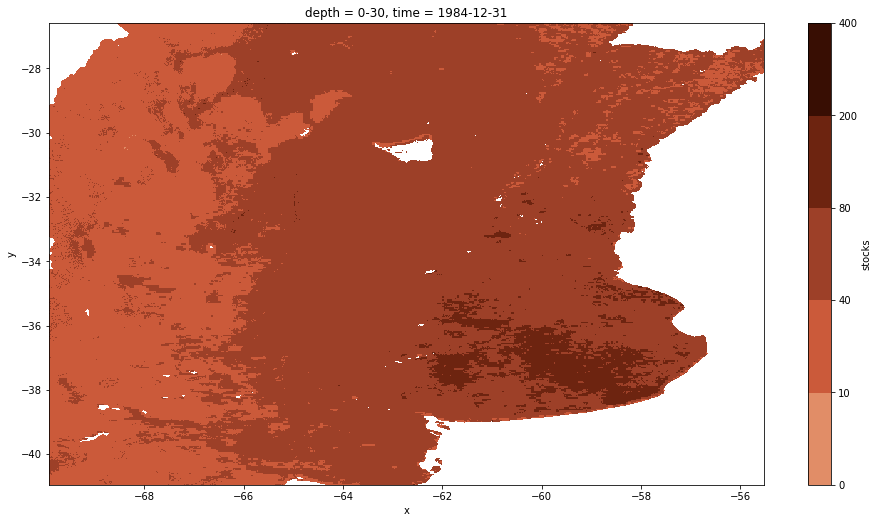

In [6]:
%%time
colors = ["#E18D67", "#CB5A3A", "#9D4028", "#6D2410", "#380E03"]
quantities = [0, 10, 40, 80, 200, 400]
show_xarray(xds['stocks'][0,2,2000:8000,2000:8000], colors, quantities)

## Read vector data
**Political boundaries**

/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


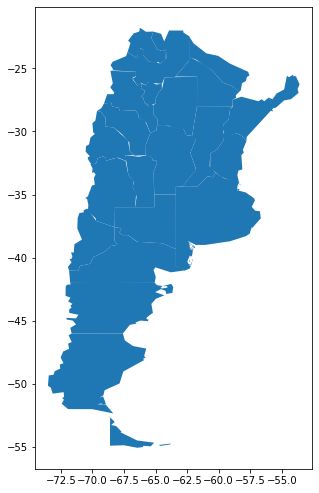

In [7]:
account = "wri-01"
query = "SELECT name_0, name_1, gid_0, gid_1, the_geom FROM gadm36_political_boundaries WHERE level = 1 and gid_0 = 'ARG'"

df = df_from_carto(account, query)

df['geometry'] = df['geometry'].apply(lambda x: x.simplify(0.1))

fig, ax = plt.subplots(figsize=(16,8.5))
df.plot(ax=ax)

## Zonal statistics
**Raster data**

In [8]:
raster = xds.stocks.squeeze().drop("depth")
raster.name = "raster"
raster

,Array,Chunk
Bytes,19.74 GB,6.43 MB
Shape,"(36, 13883, 9872)","(3, 868, 617)"
Count,6145 Tasks,3072 Chunks
Type,float32,numpy.ndarray


In [9]:
raster = raster[0,:,:].squeeze().drop("time")
#raster = raster.assign_coords({"spatial_ref": (np.array(0))})
#raster = raster.transpose()
raster

<xarray.DataArray 'raster' (y: 13883, x: 9872)>
dask.array<getitem, shape=(13883, 9872), dtype=float32, chunksize=(868, 617), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 -74.7 -74.7 -74.7 -74.7 ... -51.05 -51.05 -51.05 -51.05
  * y        (y) float64 -21.79 -21.79 -21.79 -21.79 ... -55.05 -55.05 -55.06
Attributes:
    AREA_OR_POINT:     Area
    TIFFTAG_SOFTWARE:  GRASS GIS 7.6.0 with GDAL 2.2.2
    crs:               +init=epsg:4326
    is_tiled:          1
    nodatavals:        [-9999.0]
    offsets:           [0.0]
    res:               [0.0023966782079451365, 0.0023966782079451365]
    scales:            [1.0]
    transform:         [0.0023966782079451365, 0.0, -74.70544001621114, 0.0, ...

In [ ]:
raster.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)
raster.rio.set_crs("epsg:4326", inplace=True)

**Create the data mask by rasterizing the vector data**

In [10]:
df.reset_index(level=0, inplace=True)
df.head()

,index,name_0,name_1,gid_0,gid_1,geometry
0,0,Argentina,Santa Cruz,ARG,ARG.20_1,"MULTIPOLYGON (((-65.71570 -47.90490, -65.71070..."
1,1,Argentina,Misiones,ARG,ARG.14_1,"POLYGON ((-55.37430 -28.03480, -55.55780 -28.1..."
2,2,Argentina,Formosa,ARG,ARG.9_1,"POLYGON ((-58.24600 -26.73130, -58.38060 -26.8..."
3,3,Argentina,Santiago del Estero,ARG,ARG.22_1,"POLYGON ((-61.99760 -29.67890, -62.12610 -30.4..."
4,4,Argentina,Entre Ríos,ARG,ARG.8_1,"MULTIPOLYGON (((-58.52470 -33.46150, -58.40260..."


In [11]:
%%time
out_grid = make_geocube(
    vector_data=df,
    measurements=["index"],
    like=raster, # ensure the data are on the same grid
    fill=np.nan
)
out_grid

KeyError: 'longitude'

***
## Create `xarray.Dataset` in memory

In [12]:
Historic_SOCS_2010 = 'https://storage.googleapis.com/vizz-data-transfer/SOC_maps/Historic/SOCS_0_200cm_year_2010AD_10km.tif'

In [13]:
xda = rioxarray.open_rasterio(Historic_SOCS_2010)
xda

<xarray.DataArray (band: 1, y: 2004, x: 4008)>
[8032032 values with dtype=int16]
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 89.97 89.88 89.79 89.7 ... -89.79 -89.88 -89.97
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
    spatial_ref  int64 0
Attributes:
    transform:     (0.08983152841195215, 0.0, -180.0223829375521, 0.0, -0.089...
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     b1
    grid_mapping:  spatial_ref

In [14]:
xda.coords['spatial_ref']

<xarray.DataArray 'spatial_ref' ()>
array(0)
Coordinates:
    spatial_ref  int64 0
Attributes:
    spatial_ref:  GEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSO...
    crs_wkt:      GEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSO...

In [15]:
xda.rio.crs

CRS.from_epsg(4326)

In [16]:
raster = xda.squeeze().drop("band")
raster.name = "raster"
raster

<xarray.DataArray 'raster' (y: 2004, x: 4008)>
[8032032 values with dtype=int16]
Coordinates:
  * y            (y) float64 89.97 89.88 89.79 89.7 ... -89.79 -89.88 -89.97
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
    spatial_ref  int64 0
Attributes:
    transform:     (0.08983152841195215, 0.0, -180.0223829375521, 0.0, -0.089...
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     b1
    grid_mapping:  spatial_ref

In [17]:
%%time
out_grid = make_geocube(
    vector_data=df,
    measurements=["index"],
    like=raster, # ensure the data are on the same grid
    fill=np.nan
)
out_grid

CPU times: user 272 ms, sys: 130 ms, total: 403 ms
Wall time: 587 ms


<xarray.Dataset>
Dimensions:      (x: 4008, y: 2004)
Coordinates:
  * y            (y) float64 89.97 89.88 89.79 89.7 ... -89.79 -89.88 -89.97
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
    spatial_ref  int64 0
Data variables:
    index        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    grid_mapping:  spatial_ref